## Compare SV callsets of Manta, DELLY, LUMPY and GRIDSS in Venn and/or UpSetR diagrams

The VCF files were filtered/merged using SURVIVOR:

```
SURVIVOR filter [VCF] ENCFF001TDO.bed -1 -1 0 -1 [VCF]
SURVIVOR merge [TXT] 100 1 0 0 0 0 [VCF]
```

### SV detection in two WGS datasets: 
- single-sample **benchmark** data for _germline_ SVs
- paired-sample **cell lines** data for _somatic_ SVs

In [1]:
library(tools)
library(ggplot2)
library(venn)
library(UpSetR)
library(vcfR)


   *****       ***   vcfR   ***       *****
   This is vcfR 1.8.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****



In [2]:
options(jupyter.plot_mimetypes="image/svg+xml") # set the MIME type of the plots (or "image/png")

### required data dirs/paths:

```
..benchmark/compare/callers  # 4 x callsets generated by the SV callers 
..cell_lines/compare/callers # ""
..benchmark/compare/samples  # 10 x callsets generated from sample copies per SV caller 
..cell_lines/compare/samples # ""
```

In [3]:
base.dir <- file.path('..', '..')
dirs <- merge(c("benchmark", "cell_lines"), c("callers", "samples"))
paths <- file.path(base.dir, dirs$x, 'compare', dirs$y)

In [4]:
print(paths)

[1] "../../benchmark/compare/callers"  "../../cell_lines/compare/callers"
[3] "../../benchmark/compare/samples"  "../../cell_lines/compare/samples"


In [5]:
callers <- c("all", "manta", "delly", "lumpy", "gridss")

### store all comparisons in a table

In [6]:
tab <- merge(paths[1:2], callers[1])
tab <- rbind(tab, merge(paths[3:4], callers[2:5]))
names(tab) <- c("path", "callset")
print(tab)

                               path callset
1   ../../benchmark/compare/callers     all
2  ../../cell_lines/compare/callers     all
3   ../../benchmark/compare/samples   manta
4  ../../cell_lines/compare/samples   manta
5   ../../benchmark/compare/samples   delly
6  ../../cell_lines/compare/samples   delly
7   ../../benchmark/compare/samples   lumpy
8  ../../cell_lines/compare/samples   lumpy
9   ../../benchmark/compare/samples  gridss
10 ../../cell_lines/compare/samples  gridss


### select a comparison

In [7]:
ri <- 1  # row index
row <- tab[ri,]
row

path,callset
<fct>,<fct>
../../benchmark/compare/callers,all


In [8]:
sets <- read.table(file.path(row$path, paste0(row$callset, ".txt")), colClasses="character")

In [9]:
#sets

In [10]:
if (ri < 3) {
    sets <- toupper(gsub("(\\d+)\\/.*\\/(.*)", "\\2", file_path_sans_ext(sets$V1)))
} else {
    sets <- toupper(gsub("(\\d+)\\/.*\\/(.*)", "\\2-\\1", file_path_sans_ext(sets$V1)))
}

In [11]:
#sets

In [12]:
n.sets <- length(sets)

In [13]:
#n.sets

In [14]:
vcf <- read.vcfR(file.path(row$path, paste0(row$callset, ".vcf")), verbose = FALSE)

In [15]:
bin.vec <- sapply(strsplit(sapply(strsplit(getFIX(vcf, getINFO=TRUE)[, 'INFO'], ";"), function(x) {x[2]}), "="), function (x) {x[2]})

In [16]:
#bin.vec

In [17]:
sets.sz <- data.frame(matrix(ncol=2, nrow=n.sets))

In [18]:
names(sets.sz) <- c("caller", "n")

In [19]:
for (i in 1:n.sets) {
    s <- rep(".",n.sets)
    s <- paste(replace(s,i,1), collapse="")
    re <- paste("^",s, "$", sep="")
    caller <- sets[i]
    n <- length(grep(s, bin.vec))
    sets.sz[i,] <- c(caller, n)
    #print(paste(caller, n))
}

In [20]:
#sets.sz

In [21]:
vec <- table(sapply(bin.vec, function(x) {strtoi(x, base=2)}))

In [22]:
#vec

In [23]:
lst <- strsplit(bin.vec, "")

In [24]:
#lst

In [25]:
s <- as.character(seq(0, (2 ** n.sets - 1)))

In [26]:
#s

In [27]:
N <- sapply(s, function(x){vec[x]}, USE.NAMES=FALSE)

In [28]:
N[is.na(N)] <- 0

In [29]:
#N

In [30]:
slabels <- paste0(sets.sz$caller, " (", sets.sz$n, ")")

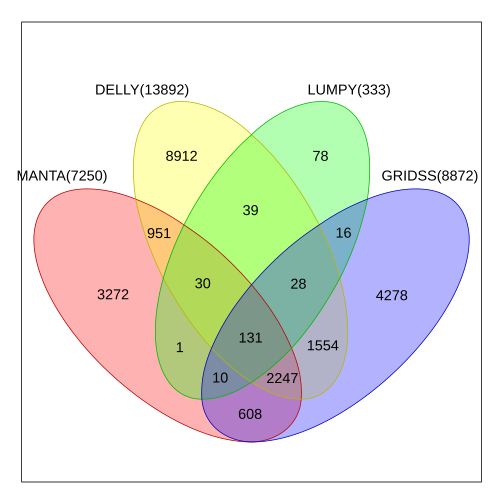

In [31]:
if (ri < 3) {
    venn(n.sets, counts=N, snames=slabels, ilabels=TRUE, cexil=1.2, cexsn=1.2, zcolor="style", ellipse=TRUE)
}

In [32]:
nr <- length(lst)

In [33]:
#nr

In [34]:
nc <- length(lst[[1]])

In [35]:
#nc

In [36]:
M <- matrix(0, nrow=nr, ncol=nc)

In [37]:
for (i in 1:nr) {
  M[i, ] <- as.integer(lst[[i]])
}

In [38]:
#M

In [39]:
sv <- data.frame(ID = getFIX(vcf)[, "ID"], M)

In [40]:
#colnames(sv)

In [41]:
colnames(sv)[-1] <- slabels

In [42]:
#sv

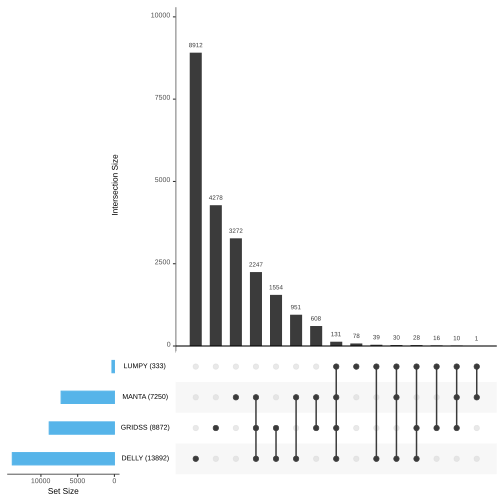

In [43]:
upset(sv, nsets=n.sets, sets.bar.color="#56B4E9", order.by="freq")